## Modeling for predicting 72h ED revisit at ED discharge

Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve, get_lstm_data_gen
from dataset_path import output_path

path = output_path

output_path = os.path.join(path, "Figure3")
if not os.path.exists(output_path):
    os.makedirs(output_path)
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_validation = pd.read_csv((os.path.join(path, 'validation.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 42

2022-08-19 19:43:26.294458: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
pd.set_option('display.max_columns', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,cci_Liver2,cci_Cancer2,cci_HIV,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,47399,18336789,NaN,33947176,2204-07-21 18:27:00,2204-07-21 18:37:00,71,F,2197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2204,78,False,False,False,0 days 00:10:00,NaN,NaN,False,False,False,1,1,1,NaN,NaN,False,0,0,0,0,0,0,0.17,NaN,NaN,36.444444,88.0,18.0,98.0,152.0,76.0,10.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37.111111,92.0,18.0,98.0,146.0,84.0,0.0,0.0,15.0,101.333333,3,9,6,0,0,1
1,187780,13712250,23685749.0,37806132,2185-08-06 23:42:00,2185-08-08 14:09:00,67,F,2176,NaN,2185-08-07 04:18:00,2185-08-08 14:09:00,NaN,BLACK/AFRICAN AMERICAN,2185-08-06 23:42:00,2185-08-08 14:09:00,Other,2185,76,False,False,False,1 days 14:27:00,NaN,NaN,False,True,False,0,0,1,NaN,NaN,False,0,0,1,0,0,0,38.45,NaN,NaN,36.444444,66.0,17.0,100.0,119.0,68.0,10.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,36.722222,51.0,16.0,98.0,115.0,66.0,8.0,12.0,11.0,85.000000,3,9,8,0,0,1
2,432843,17236922,NaN,30242272,2165-02-28 04:37:00,2165-02-28 04:54:00,63,M,2163,NaN,NaN,NaN,NaN,WHITE,NaN,NaN,NaN,2165,65,False,False,False,0 days 00:17:00,NaN,NaN,False,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,0.28,NaN,NaN,36.777778,85.0,20.0,96.0,169.0,100.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.722222,82.0,18.0,96.0,137.0,90.0,0.0,0.0,4.0,123.000000,3,4,7,0,0,1
3,307634,15057835,28433076.0,34192717,2172-05-05 03:39:00,2172-05-05 05:46:00,68,M,2171,NaN,2172-05-05 04:19:00,2172-05-07 14:00:00,NaN,WHITE,2172-05-05 03:39:00,2172-05-05 05:46:00,Medicare,2172,69,False,False,False,0 days 02:07:00,NaN,NaN,False,True,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,2.12,NaN,NaN,37.222222,50.0,19.0,96.0,138.0,76.0,0.0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.833333,56.0,19.0,99.0,148.0,78.0,0.0,2.0,2.0,96.666667,3,4,8,1,1,2
4,210916,17800278,NaN,35819741,2165-09-26 17:30:00,2165-09-26 17:36:00,76,M,2158,NaN,NaN,NaN,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,NaN,2165,83,False,False,False,0 days 00:06:00,NaN,NaN,False,False,False,1,9,17,2165-11-07 16:21:00,41 days 22:45:00,False,0,3,7,0,0,0,0.10,NaN,41.95,37.000000,80.0,16.0,100.0,156.0,98.0,4.0,...,0,0,0,1,1,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,37.000000,80.0,16.0,100.0,156.0,98.0,0.0,0.0,0.0,117.333333,11,9,8,0,0,1


In [3]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [4]:
df_train = df_train[(df_train['before_ed_mortality'] == False) & (df_train['outcome_hospitalization'] == False) & (df_train['ed_death'] == False)]
df_validation = df_validation[(df_validation['before_ed_mortality'] == False) & (df_validation['outcome_hospitalization'] == False) & (df_validation['ed_death'] == False)]
df_test = df_test[(df_test['before_ed_mortality'] == False) & (df_test['outcome_hospitalization'] == False) & (df_test['ed_death'] == False)]

### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_ed_revisit_3d"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_validation = df_validation[variable].copy()
y_validation = df_validation[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_los,n_med,n_medrecon
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,object,float64,float64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_validation['gender'] = encoder.transform(X_validation['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_validation['ed_los'] = pd.to_timedelta(X_validation['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [10]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.04752870051773483 : 1


### 3.  Modeling script

In [15]:
# Containers for all results
result_list = []

Logistic Regression:
lbfgs
l2
100


/gpfs/share/apps/anaconda3/gpu/5.2.0/envs/machinelearning/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.039202690124512 seconds
0.6809800964400787
lbfgs
l2
10


/gpfs/share/apps/anaconda3/gpu/5.2.0/envs/machinelearning/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.0770416259765625 seconds
0.6811853216708244
lbfgs
l2
1.0


/gpfs/share/apps/anaconda3/gpu/5.2.0/envs/machinelearning/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.156750440597534 seconds
0.6830765760559139
lbfgs
l2
0.1


/gpfs/share/apps/anaconda3/gpu/5.2.0/envs/machinelearning/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.064647197723389 seconds
0.6807430924198645
lbfgs
l2
0.01


/gpfs/share/apps/anaconda3/gpu/5.2.0/envs/machinelearning/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 4.971073389053345 seconds
0.6816684469363691
liblinear
l1
100
Training time: 23.954658031463623 seconds
0.6919945810369871
liblinear
l1
10
Training time: 34.73673486709595 seconds
0.6919904607525594
liblinear
l1
1.0
Training time: 20.39677357673645 seconds
0.6919541671833459
liblinear
l1
0.1
Training time: 32.48625087738037 seconds
0.6903953846853148
liblinear
l1
0.01
Training time: 21.068809509277344 seconds
0.6850982330598561
liblinear
l2
100
Training time: 3.8046517372131348 seconds
0.6908048708249191
liblinear
l2
10
Training time: 4.196274280548096 seconds
0.6910413926841895
liblinear
l2
1.0
Training time: 4.401962041854858 seconds
0.6912612580744972
liblinear
l2
0.1
Training time: 3.8292970657348633 seconds
0.6911043366037434
liblinear
l2
0.01
Training time: 3.365894317626953 seconds
0.6907031348658073
AUC: 0.682601020034316
AUPRC: 0.144384386842205
Sensitivity: 0.6100746268656716
Specificity: 0.6480493648569232
Score thresold: 0.03932731575141676
2.5 97.5


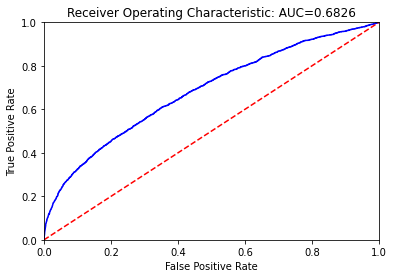

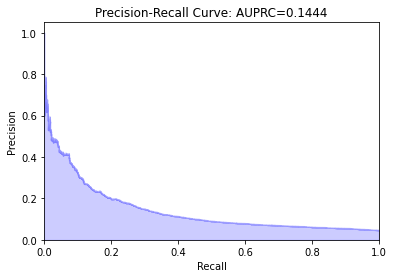

In [41]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

best_acc = 0
logreg = 0
best_model = 0
best_params = {}
result_keys = ['AUC', 'AUPRC', 'Sensitivity', 'Specificity', 
               'Threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 
               'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 
               'std_sensitivity', 'lower_specificity', 'upper_specificity', 
               'std_specificity']
c_values = [100, 10, 1.0, 0.1, 0.01]
solver_map = {
#             'newton-cg': ['l2'],
            'lbfgs': ['l2'],
            'liblinear': ['l1', 'l2']}
for sol in solver_map:
    for reg in solver_map[sol]:
        for c in c_values:
            print(sol)
            print(reg)
            print(c)
            logreg=LogisticRegression(solver=sol, penalty=reg, C=c)
            start = time.time()
            logreg.fit(X_train,y_train)
            runtime = time.time()-start
            print('Training time:', runtime, 'seconds')
            probs = logreg.predict_proba(X_validation)
            fpr, tpr, _ = metrics.roc_curve(y_validation,probs[:,1])
            roc_auc = metrics.auc(fpr, tpr)
            print(roc_auc)
            if roc_auc > best_acc:
                best_acc = roc_auc
                best_model = logreg
                best_result = dict(zip(result_keys, result))
                best_params = {'solver': sol, 'penalty': reg, 'C': c}

probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

In [42]:
# print("RandomForest:")
# from sklearn.ensemble import RandomForestClassifier
# rf= RandomForestClassifier()
# start = time.time()
# rf.fit(X_train,y_train)
# runtime = time.time()-start
# print('Training time:', runtime, 'seconds')
# probs = rf.predict_proba(X_test)
# result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
# importances = rf.feature_importances_
# print(importances)

# results = ["RF"]
# results.extend(result)
# results.append(runtime)
# result_list.append(results)

In [43]:
# print("GradientBoosting:")
# from sklearn.ensemble import GradientBoostingClassifier
# gb = GradientBoostingClassifier()
# start = time.time()
# gb.fit(X_train, y_train)
# runtime = time.time()-start
# print('Training time:', runtime, 'seconds')
# probs = gb.predict_proba(X_test)
# result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

# results = ["GB"]
# results.extend(result)
# results.append(runtime)
# result_list.append(results)

In [44]:
# class MLP(tf.keras.Model):
#     def __init__(self):
#         super(MLP, self).__init__()
#         self.dense_1 = Dense(128, activation='relu')
#         self.dense_2 = Dense(64, activation='relu')
#         self.classifier = Dense(1, activation='sigmoid')

#     def call(self, x):
#         x = self.dense_1(x)
#         x = self.dense_2(x)
#         return self.classifier(x)

In [45]:
# # skip this cell if not retraining
# mlp = MLP()
# mlp.compile(loss='binary_crossentropy', 
#               optimizer=optimizers.Adam(learning_rate=0.001), 
#               metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
#                        'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
# start = time.time()
# mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
# runtime = time.time() - start
# print('Training time:', runtime, 'seconds')
# mlp.save('72h_ed_revisit_mlp')

In [46]:
# print("MLP:")
# #mlp = load_model('72h_ed_revisit_mlp')
# probs = mlp.predict(X_test.astype(np.float32))
# result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
# results = ["MLP"]
# results.extend(result)
# results.append(runtime)
# result_list.append(results)

In [47]:
# # Loading data for LSTM
# resample_freq = '1H' #'30T'
# df_vitalsign = pd.read_csv(os.path.join(path, 'ed_vitalsign_' + resample_freq + '_resampled.csv'))

In [48]:
# train_data_gen, test_data_gen = get_lstm_data_gen(df_train, df_test, df_vitalsign, variable, outcome)

In [49]:
# class LSTM_MLP(tf.keras.Model):
#     def __init__(self):
#         super(LSTM_MLP, self).__init__()
#         self.dense_1 = Dense(96, activation='relu')
#         self.lstm = LSTM(32)
#         self.dense_2 = Dense(64, activation='relu')
#         self.classifier = Dense(1, activation='sigmoid')
        
#     def call(self, x):
#         x1, x2 = x
#         x = self.dense_1(x1)
#         lstm_output = self.lstm(x2)
#         x = concatenate([x, lstm_output])
#         x = self.dense_2(x)
#         return self.classifier(x)

In [50]:
# # skip this cell if not retraining
# lstm = LSTM_MLP()
# lstm.compile(loss='binary_crossentropy', 
#               optimizer=optimizers.Adam(learning_rate=0.001), 
#               metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')}, 
#                        'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])

# start = time.time()
# lstm.fit(train_data_gen, batch_size=200, epochs=20)
# runtime = time.time() - start
# print('Training time:', runtime, 'seconds')
# lstm.save('72h_ed_revisit_lstm')

In [51]:
# print("LSTM:")
# lstm = load_model('72h_ed_revisit_lstm')
# probs = lstm.predict(test_data_gen)
# result = PlotROCCurve(probs, y_test, ci=confidence_interval, random_seed=random_seed)
# results = ["LSTM"]
# results.extend(result)
# results.append(runtime)
# result_list.append(results)

In [52]:
# # Temporal skip
# '''
# print("Support Vector Machine:")
# from sklearn.svm import SVC
# svc=SVC()
# start = time.time()
# svc.fit(X_train,y_train)
# runtime = time.time()-start
# print('Training time:', runtime, 'seconds')
# probs = svc.predict_proba(X_test)
# result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

# results = ["SVM"]
# results.extend(result)
# results.append(runtime)
# result_list.append(results)
# '''

In [53]:
# def get_score_performance(s, random_seed=0):
#     print(s)
#     score = np.array(df_test[s])
#     result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
#     runtime = 0
#     results = [s]
#     results.extend(result)
#     results.append(runtime)
#     result_list.append(results)


In [54]:
# ## input AutoScore result from csv (implemented by R, detail: https://github.com/nliulab/AutoScore)
# AutoScore_pred = pd.read_csv((os.path.join(path, 'AutoScore_ED_revisit.csv')))
# df_test["AutoScore"] = AutoScore_pred["pred_score"]

In [55]:
# get_score_performance("AutoScore", random_seed=random_seed) 

In [56]:
# import tensorflow as tf
# tf.random.set_seed(random_seed)
# import tensorflow.keras as keras
# from tensorflow.keras import optimizers, metrics, layers, Model
# from embedding import *

In [57]:
# print("Med2Vec:")
# version = 'v10'
# batch_size=200
# vocabulary = vocabulary_map[version]
# df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
# df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
# df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

# train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


In [58]:
# # To train from scratch, set load_model to None
# load_model = "embedding_revisit_"+version 
# save_model = "embedding_revisit_"+version

# if load_model:
#         model = keras.models.load_model(load_model)
# else:
#         model = create_embedding_model(vocabulary, len(variable))
# model.summary()
# model.compile(loss='binary_crossentropy', 
#         optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
#         metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
#                     'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
# runtime = 1063.299
# if not load_model:
#         start = time.time()
#         model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
#         runtime = time.time()-start
#         print('Training time:', runtime, 'seconds')
# if save_model:
#         keras.models.save_model(model, save_model)
# output = model.predict(test_gen)
# result = PlotROCCurve(output,y_test, ci=confidence_interval, random_seed=random_seed)

# results = ["Med2Vec"]
# results.extend(result)
# results.append(runtime)
# result_list.append(results)

### 4. Performance output

In [59]:
# #result_df = pd.read_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'))
# result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
# result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
# result_df = result_df.round(3)
# formatted_result_df = pd.DataFrame()
# formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
# formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
#                                '-' + result_df['upper_auroc'].astype(str) + ')'
# formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
#                                '-' + result_df['upper_ap'].astype(str) + ')'
# formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
#                                      '-' + result_df['upper_sensitivity'].astype(str) + ')'
# formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
#                                      '-' + result_df['upper_specificity'].astype(str) + ')'
# formatted_result_df[['Runtime']] = result_df[['runtime']]
# formatted_result_df.to_csv(os.path.join(path, 'task3.csv'), index=False)
# formatted_result_df

In [60]:
# from helpers import plot_confidence_interval
# #plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC" )
# plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
#                          my_file = 'AUROC_72h.eps', my_path = output_path) 

In [61]:
# plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
#                          my_file = 'AUPRC_72h.eps', my_path = output_path)

In [62]:
# importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
# importance_df.to_csv(os.path.join(path, 'importances_72h_ed_revisit_disposition.csv'))
# importance_df.sort_values(by='Importance', axis=0,ascending=False)